Green displacement: (1, -5)
Red displacement: (-4, 15)


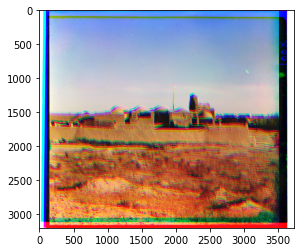

Final Green displacement: (7, -15)
Final Red displacement: (-24, 41)


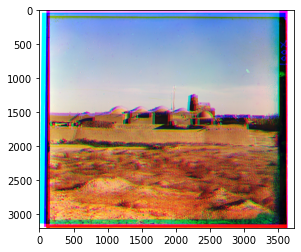

In [48]:
import numpy as np
import skimage.io as skio
from skimage.transform import rescale
import skimage.util as sku
import matplotlib.pyplot as plt

def align(im1, im2, max_disp):
    #Aligns im1 to im2 within a window of max_disp pixels using exhaustive search
    best_offset = (0, 0)
    best_score = float('inf')
    
    for dx in range(-max_disp, max_disp+1):
        for dy in range(-max_disp, max_disp+1):
            shifted = np.roll(np.roll(im1, dx, axis=1), dy, axis=0)
            score = np.sum((shifted - im2) ** 2)
            if score < best_score:
                best_score = score
                best_offset = (dx, dy)
    
    return best_offset

def crop_to_smallest(b, g, r):
    #Crops all channels (B, G, R) to the smallest size
    min_height = min(b.shape[0], g.shape[0], r.shape[0])
    min_width = min(b.shape[1], g.shape[1], r.shape[1])
    
    b = b[:min_height, :min_width]
    g = g[:min_height, :min_width]
    r = r[:min_height, :min_width]
    
    return b, g, r

def save_offsets(g_offset, r_offset, filename='offsets.txt'):
    #Saves the calculated offsets to a text file
    with open(filename, 'w') as f:
        f.write(f"Green Offset: {g_offset}\n")
        f.write(f"Red Offset: {r_offset}\n")

def align_and_merge(imname, max_disp=15):
    #Takes a 3-channel image, aligns G and R to B, and outputs a color image
    
    im = skio.imread(imname)
    im = sku.img_as_float(im).astype(np.float32)
    
    height = im.shape[0] // 3
    
    b = im[:height]
    g = im[height: 2 * height]
    r = im[2 * height: 3 * height]
    
    b, g, r = crop_to_smallest(b, g, r)
    
    g_offset = align(g, b, max_disp)
    r_offset = align(r, b, max_disp)
    
    print(f"Green displacement: {g_offset}")
    print(f"Red displacement: {r_offset}")
    
    save_offsets(g_offset, r_offset, filename='offsets.txt')
    
    g_aligned = np.roll(np.roll(g, g_offset[0], axis=1), g_offset[1], axis=0)
    r_aligned = np.roll(np.roll(r, r_offset[0], axis=1), r_offset[1], axis=0)
    
    im_out = np.dstack([r_aligned, g_aligned, b])
    
    im_out = (im_out * 255).astype(np.uint8)
    
    skio.imsave('aligned_output.jpg', im_out)
    
    plt.imshow(im_out)
    plt.show()

def image_pyramid(imname, max_disp=15, num_levels=3):
    #Creates an image pyramid and aligns using a coarse-to-fine approach
    
    im = skio.imread(imname)
    im = sku.img_as_float(im).astype(np.float32)

    pyramid = [im]
    for level in range(1, num_levels):
        scaled_image = rescale(pyramid[-1], 0.5, anti_aliasing=True, channel_axis=-1)
        pyramid.append(scaled_image)
    
    b = pyramid[-1][:pyramid[-1].shape[0] // 3]
    g = pyramid[-1][pyramid[-1].shape[0] // 3: 2 * pyramid[-1].shape[0] // 3]
    r = pyramid[-1][2 * pyramid[-1].shape[0] // 3:]
    
    b, g, r = crop_to_smallest(b, g, r)

    g_offset = align(g, b, max_disp // (2 ** (num_levels - 1)))
    r_offset = align(r, b, max_disp // (2 ** (num_levels - 1)))
    
    for level in reversed(range(num_levels - 1)):
        g_offset = (g_offset[0] * 2, g_offset[1] * 2)
        r_offset = (r_offset[0] * 2, r_offset[1] * 2)
        
        b = pyramid[level][:pyramid[level].shape[0] // 3]
        g = pyramid[level][pyramid[level].shape[0] // 3: 2 * pyramid[level].shape[0] // 3]
        r = pyramid[level][2 * pyramid[level].shape[0] // 3:]
        
        b, g, r = crop_to_smallest(b, g, r)

        g_offset = tuple(map(sum, zip(g_offset, align(g, b, max_disp // (2 ** level)))))
        r_offset = tuple(map(sum, zip(r_offset, align(r, b, max_disp // (2 ** level)))))
    
    print(f"Final Green displacement: {g_offset}")
    print(f"Final Red displacement: {r_offset}")
    
    save_offsets(g_offset, r_offset, filename='pyramid_offsets.txt')
    
    g_aligned = np.roll(np.roll(g, g_offset[0], axis=1), g_offset[1], axis=0)
    r_aligned = np.roll(np.roll(r, r_offset[0], axis=1), r_offset[1], axis=0)
    
    im_out = np.dstack([r_aligned, g_aligned, b])
    
    im_out = (im_out * 255).astype(np.uint8)
    
    skio.imsave('pyramid_output.jpg', im_out)
    
    plt.imshow(im_out)
    plt.show()

align_and_merge('mosque.tif', max_disp=15)

image_pyramid('mosque.tif', max_disp=15, num_levels=3)
